# Notebook 2: HMM Training, Analysis, and Visualization

**Objective:** Load the logged inference trajectories, train an HMM surrogate, analyze its learned states, and visualize its behavior on test reviews.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle # to save data for clustering

# Add src directory to Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import (
    LOG_FILE_PATH, HMM_MODEL_PATH, TARGET_SENTIMENT,
    NUM_TEST_SAMPLES, MAX_TOKENS, MODEL_NAME, DEVICE, 
    COLOR_LOG_FILE_PATH, PLOT_SAVE_PATH
)

from src.hmm_surrogate import HMMSurrogate
from src.data_utils import load_imdb_data, preprocess_data_for_inference_logging
from src.black_box_model import BlackBoxSentimentClassifier, log_inference_trajectories
from src.visualization_utils import plot_state_timeline, plot_hmm_transition_matrix, plot_avg_probabilities_per_state, plot_gaussian_emissions
from src.clustering_utils import save_color_log
from src.convergence_utils import (plot_log_likelihoods, 
    save_convergence_data, plot_state_chain_acf, 
    posterior_predictive_check, mean_run_length,
    simulate_state_sequences,posterior_predictive_check_model_based)

%matplotlib inline

/home/giovanni/miniconda3/envs/pmlproj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Logged Inference Trajectories

In [2]:
try:
    loaded_data = np.load(LOG_FILE_PATH)
    train_trajectories = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))]
    print(f"Loaded {len(train_trajectories)} trajectories from {LOG_FILE_PATH}.")
    if train_trajectories:
        print(f"Example trajectory 0 shape: {train_trajectories[0].shape}")
except FileNotFoundError:
    print(f"Error: Log file {LOG_FILE_PATH} not found. Please run Notebook 1 first.")
    train_trajectories = []

Loaded 25000 trajectories from data/imbd_inference_logs25k.npz.
Example trajectory 0 shape: (512, 2)


## 2. Train HMM Surrogate

In [3]:
# hmm_surrogate_model = None
# if train_trajectories:
#     hmm_surrogate_model = HMMSurrogate() # Uses N_HMM_STATES from config
#     hmm_surrogate_model.train(train_trajectories)
    
#     # Save the trained HMM model
#     if not os.path.exists('models'):
#         os.makedirs('models')
#     hmm_surrogate_model.save_model(HMM_MODEL_PATH)
# else:
#     print("Skipping HMM training as no trajectories were loaded.")

In [4]:
# hmm_surrogate_model = HMMSurrogate.load_model(HMM_MODEL_PATH)

## 3. Analyze HMM Parameters and States

If you didn't just train, you can load a pre-trained HMM model.

In [5]:
hmm_surrogate_model = None

Attempting to load pre-trained HMM from models/sentiment_hmm25k.pkl
HMM model loaded from models/sentiment_hmm25k.pkl has 3 states

--- HMM Parameters ---
Initial state probabilities (startprob_):
 [0. 0. 1.]

Transition matrix (transmat_):
 [[9.96086617e-01 7.95967387e-07 3.91258738e-03]
 [4.04980734e-05 9.94757022e-01 5.20247977e-03]
 [6.94790153e-03 8.09629888e-03 9.84955800e-01]]

Emission probabilities (means_ for GaussianHMM):
 [[0.98721517 0.01278483]
 [0.01598306 0.98401694]
 [0.49240775 0.50759225]]

Emission covariances (covars_ for GaussianHMM):
 [[[ 8.14502482e-05 -8.14408217e-05]
  [-8.14408217e-05  8.14502485e-05]]

 [[ 1.32100658e-04 -1.32091372e-04]
  [-1.32091372e-04  1.32100658e-04]]

 [[ 1.12701355e-01 -1.12701347e-01]
  [-1.12701347e-01  1.12701355e-01]]]

--- HMM State Analysis ---
State 0: Occurrences = 2122638, Avg. P(Class 1) = 0.013
State 1: Occurrences = 2154843, Avg. P(Class 1) = 0.995
State 2: Occurrences = 2605105, Avg. P(Class 1) = 0.507

Suggested State I

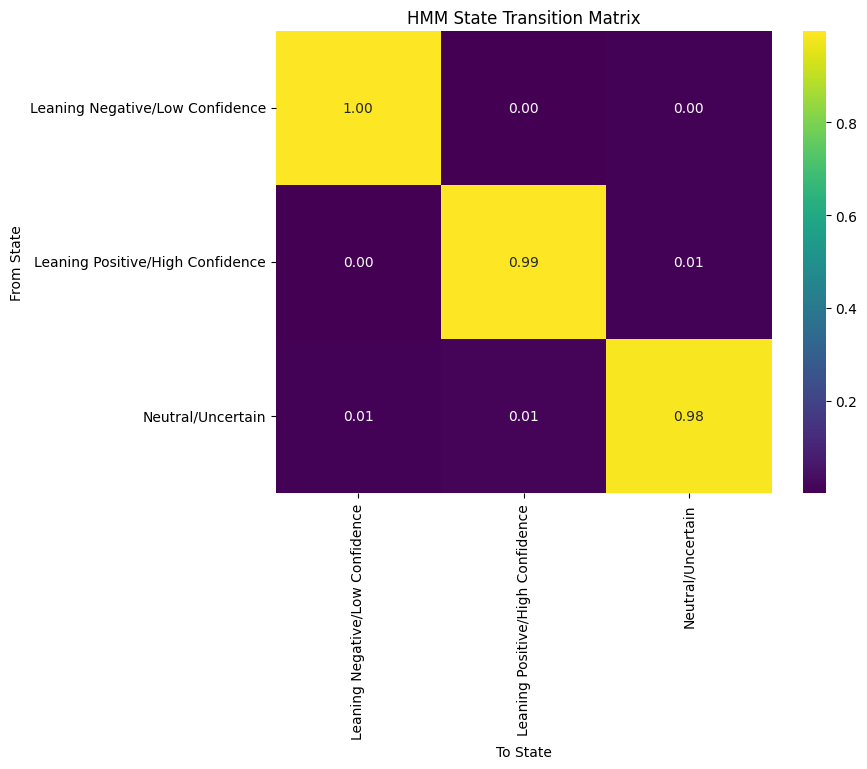

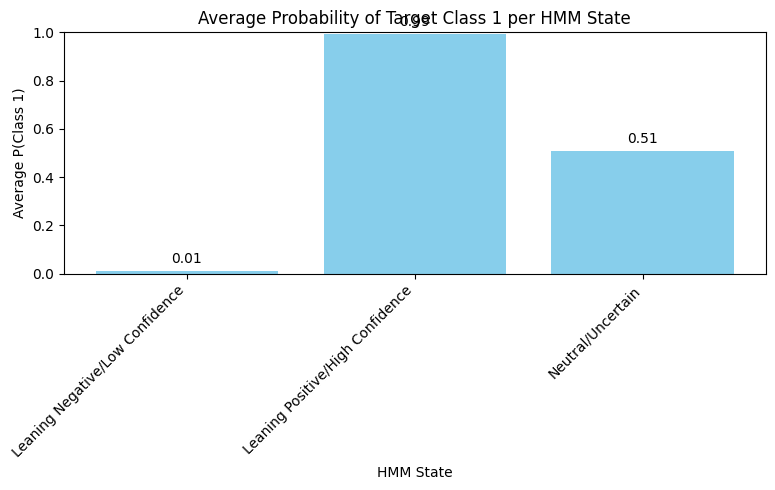

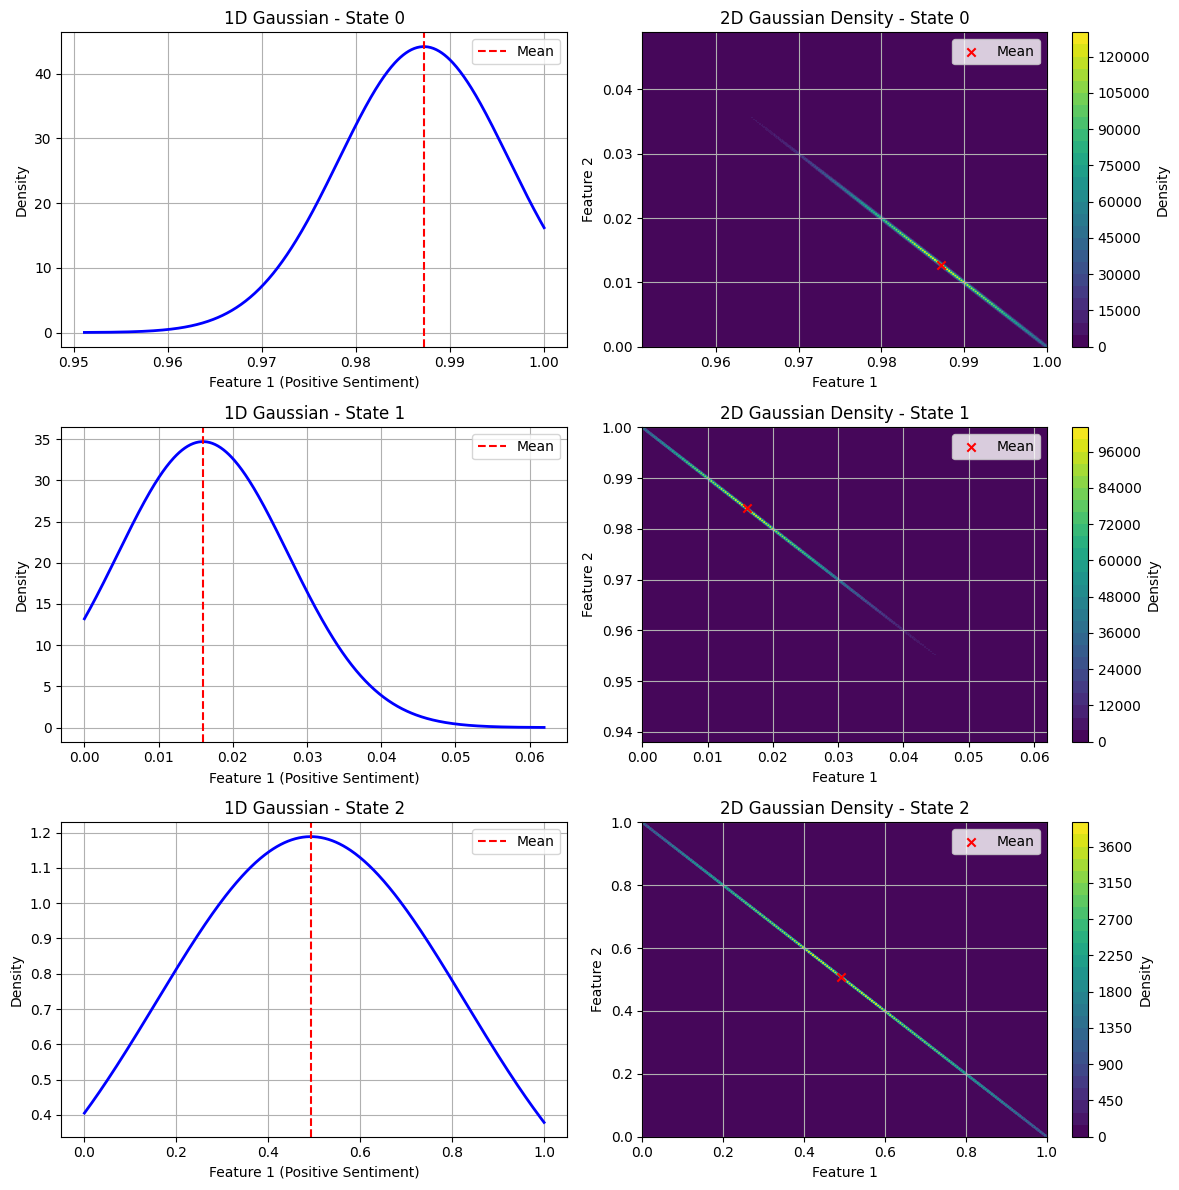

Saved grid plot to "plots/gaussian_emissions_grid.png".


In [6]:
if hmm_surrogate_model is None or not hmm_surrogate_model.is_trained:
    print(f"Attempting to load pre-trained HMM from {HMM_MODEL_PATH}")
    try:
        hmm_surrogate_model = HMMSurrogate()
        hmm_surrogate_model.load_model(HMM_MODEL_PATH)
    except FileNotFoundError:
        print(f"Error: Pre-trained HMM model not found at {HMM_MODEL_PATH}. Please train one first.")
        hmm_surrogate_model = None # Ensure it's None if loading fails

state_analysis_results = None
if hmm_surrogate_model and hmm_surrogate_model.is_trained and train_trajectories:
    # For state analysis, we need decoded states for the training trajectories
    decoded_train_states = [hmm_surrogate_model.decode_sequence(traj) for traj in train_trajectories if traj.shape[0] > 0]
    
    # Filter out empty sequences from train_trajectories if their decoded_train_states are empty
    valid_train_trajectories = [traj for traj, states in zip(train_trajectories, decoded_train_states) if states.size > 0]
    valid_decoded_train_states = [states for states in decoded_train_states if states.size > 0]
    
    state_analysis_results = hmm_surrogate_model.analyze_states(
        valid_train_trajectories, 
        valid_decoded_train_states, 
        target_class_idx=TARGET_SENTIMENT
    )
    
    # Visualize HMM parameters
    plot_hmm_transition_matrix(hmm_surrogate_model.model, state_names=state_analysis_results.get('state_names'))
    plot_avg_probabilities_per_state(state_analysis_results, target_class_idx=TARGET_SENTIMENT)
    
    #Plot emission probabilities
    plot_gaussian_emissions(hmm_surrogate_model.model.means_, hmm_surrogate_model.model.covars_)

Save data for convergence diagnostics

In [ ]:
# Make sure the directory exists
os.makedirs("notebooks/convergence_diagnostics", exist_ok=True)

# Save using pickle
with open("notebooks/convergence_diagnostics/valid_decoded_train_states.pkl", "wb") as f:
    pickle.dump(valid_decoded_train_states, f)
print("Convergence data saved successfully!")

## 4. Visualize HMM Behavior on Test Reviews

Load a few test reviews, get their black-box probability trajectories, decode HMM states, and plot.

In [ ]:
if hmm_surrogate_model and hmm_surrogate_model.is_trained and state_analysis_results:
    print("\n--- Visualizing HMM on Test Reviews ---")
    # Load black-box model for generating test trajectories
    bb_model_vis = BlackBoxSentimentClassifier(model_name=MODEL_NAME, device=DEVICE)
    tokenizer_vis = bb_model_vis.tokenizer

    # Load some test data
    imdb_test_raw = load_imdb_data(split='test', num_samples=NUM_TEST_SAMPLES, shuffle=False)
    processed_test_data = preprocess_data_for_inference_logging(imdb_test_raw, tokenizer_vis)

    # Get trajectories for test data
    test_trajectories_vis = log_inference_trajectories(processed_test_data, bb_model_vis, max_len=MAX_TOKENS)
    
    # Get the actual tokens for each processed test sample (up to MAX_TOKENS)
    test_tokens_vis = []
    for item in processed_test_data:
        # Ensure [CLS] is handled consistently if present
        cls_token_id = tokenizer_vis.cls_token_id
        actual_tokens = item['tokens']
        if cls_token_id is not None and item['input_ids'][0] == cls_token_id:
             # If CLS is already first, use tokens directly
             pass # actual_tokens = item['tokens']
        elif cls_token_id is not None:
             # Prepend [CLS] token string if model adds ID but it's not in original 'tokens'
             actual_tokens = [tokenizer_vis.cls_token] + item['tokens']
        
        test_tokens_vis.append(actual_tokens[:MAX_TOKENS])


    for i, (prob_traj, tokens) in enumerate(zip(test_trajectories_vis, test_tokens_vis)):
        if prob_traj.shape[0] == 0: continue # Skip empty trajectories

        decoded_states_vis = hmm_surrogate_model.decode_sequence(prob_traj)
        
        # Ensure token list length matches trajectory length for plotting
        # The trajectory length is min(len(original_tokens_with_cls), MAX_TOKENS)
        # The `tokens` list should be sliced to match this length.
        plot_tokens = tokens[:len(decoded_states_vis)]

        print(f"\nVisualizing Test Sample {i+1}:")
        print(f"Text: {processed_test_data[i]['text'][:200]}...")
        
        plt.figure(figsize=(18, 6))
        plot_state_timeline(
            plot_tokens,
            prob_traj,
            decoded_states_vis,
            state_names=state_analysis_results.get('state_names'),
            target_class_idx=TARGET_SENTIMENT,
            ax=plt.gca() # Pass current axes
        )
        plt.show()
        
else:
    print("Skipping visualization as HMM model is not available or not trained, or state analysis is missing.")

Save color logs and data for clustering

In [ ]:
save_color_log()

np.save("data/clustering/test_trajectories_vis.npy", np.array(test_trajectories_vis, dtype=object))
with open("data/clustering/test_tokens_vis.pkl", "wb") as f:
    pickle.dump(test_tokens_vis, f)
with open("data/clustering/decoded_states_vis.pkl", "wb") as f:
    pickle.dump(decoded_states_vis, f)
print("Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl")